# 5. 상수 알파를 적용한 몬테카를로 제어 (Constant Alpha MC Control)

이전 챕터에서 다룬 몬테카를로 방법은 모든 방문에 대한 반환값의 단순 '평균'을 계산하여 값을 업데이트했다. 하지만 환경이 시간에 따라 변하는 **비정상성(Non-stationary)**을 띠거나, 초기 학습 속도를 높이고 싶을 때는 **상수 알파()**를 사용하는 이동 평균(Running Average) 방식이 더 효과적일 수 있다.

이번에는 업데이트 공식에 학습률(Learning Rate) 개념인 를 도입하여 실습을 진행한다.

### 0. 라이브러리 및 환경 설정

기존과 동일하게 `gymnasium`을 사용하며 미로 환경을 구성한다.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from IPython import display

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

In [2]:
# ---------------------------------------------------------
# 1. 커스텀 Maze 환경 정의 (Gymnasium 기반)
# ---------------------------------------------------------
class Maze(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.MultiDiscrete([5, 5]) # 5x5 그리드
        self.action_space = spaces.Discrete(4) # 0:Up, 1:Right, 2:Down, 3:Left
        self.state = np.array([0, 0])
        self.target = np.array([4, 4])
        self.render_mode = 'rgb_array'

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([0, 0])
        return self.state, {}

    def step(self, action):
        moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        move = moves[action]
        next_state = np.clip(self.state + np.array(move), 0, 4)
        self.state = next_state

        terminated = np.array_equal(self.state, self.target)
        reward = -1.0
        if terminated:
            reward = 0.0

        return self.state, reward, terminated, False, {}

    def render(self):
        grid = np.zeros((5, 5, 3), dtype=np.uint8) + 255
        grid[self.state[0], self.state[1]] = [0, 0, 255]
        grid[self.target[0], self.target[1]] = [0, 255, 0]
        return np.kron(grid, np.ones((40, 40, 1), dtype=np.uint8))

# 시각화 헬퍼 함수
def plot_action_values(action_values):
    values = np.max(action_values, axis=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(values, cmap='coolwarm', interpolation='none')
    for r in range(5):
        for c in range(5):
            plt.text(c, r, f"{values[r, c]:.1f}", ha='center', va='center', color='black')
    plt.colorbar(label='Max Q-value')
    plt.title("Action Value Table (Max Q)")
    plt.show()

def plot_policy(action_values):
    best_actions = np.argmax(action_values, axis=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.zeros((5, 5)), cmap='gray', vmin=0, vmax=1)
    arrows = {0: (0, -0.3), 1: (0.3, 0), 2: (0, 0.3), 3: (-0.3, 0)}
    for r in range(5):
        for c in range(5):
            if r == 4 and c == 4: continue
            action = best_actions[r, c]
            dx, dy = arrows[action]
            plt.arrow(c, r, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')
    plt.grid(color='white')
    plt.title("Optimal Policy (Greedy)")
    plt.show()

---

## 1. 이론: 상수 알파 업데이트

이전 장에서의 업데이트 식(평균)은 다음과 같았다.



여기서 은 방문 횟수다.

이번에 사용할 **상수 알파** 업데이트 식은 다음과 같다.



여기서 는  사이의 상수다.

이 방식은 과거의 경험()은 조금 잊고, 최근의 경험()을 만큼 더 반영하겠다는 의미를 가진다. 이를 지수 이동 평균(Exponential Moving Average)이라고도 한다.

---

## 2. 초기화 및 정책 정의

환경과 Q-테이블을 초기화하고, -탐욕적 정책 함수를 정의한다.

In [3]:
# 환경 생성
env = Maze()

# Q-테이블 초기화 (5x5x4)
action_values = np.zeros(shape=(5, 5, 4))

# Epsilon-Greedy 정책
def policy(state, epsilon=0.2):
    if np.random.random() < epsilon:
        return np.random.randint(4) # 탐험
    else:
        av = action_values[state[0], state[1]]
        return np.random.choice(np.flatnonzero(av == av.max())) # 활용 (동점자 중 랜덤)

---

## 3. 상수 알파 MC 제어 알고리즘 구현

핵심 알고리즘을 구현한다. 이전 코드와 구조는 동일하지만, 값을 업데이트하는 수식 부분만 변경된다.

In [4]:
def constant_alpha_mc_control(policy, action_values, episodes, gamma=0.99, epsilon=0.2, alpha=0.1):
    """
    alpha: 학습률 (0 < alpha <= 1). 값이 클수록 최근 보상을 더 많이 반영함.
    """

    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        done = False
        transitions = []

        # 1. 에피소드 생성
        while not done:
            action = policy(tuple(state), epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            transitions.append((state, action, reward))
            state = next_state

        # 2. Q-함수 업데이트 (Constant Alpha)
        G = 0
        for state_t, action_t, reward_t in reversed(transitions):
            G = reward_t + gamma * G

            # 좌표 unpacking
            r, c = state_t

            # [이전 방식] 1/N 평균 계산 (메모리가 필요함)
            # [현재 방식] 상수 알파를 이용한 증분 업데이트
            # Q_new = Q_old + alpha * (Target - Q_old)
            current_q = action_values[r, c, action_t]
            action_values[r, c, action_t] = current_q + alpha * (G - current_q)

    return action_values

print("알고리즘 구현 완료")

알고리즘 구현 완료


---

## 4. 학습 실행 및 비교

`alpha=0.1`로 설정하여 10,000 에피소드 동안 학습을 진행한다.

In [5]:
# 기존 Q테이블 초기화
action_values = np.zeros(shape=(5, 5, 4))

print(f"학습 시작 (alpha=0.1)...")
constant_alpha_mc_control(policy, action_values, episodes=10000, epsilon=0.2, alpha=0.1)
print("학습 완료!")

학습 시작 (alpha=0.1)...
학습 완료!


### 4.1 결과 시각화

학습된 Q값과 정책을 시각화한다.

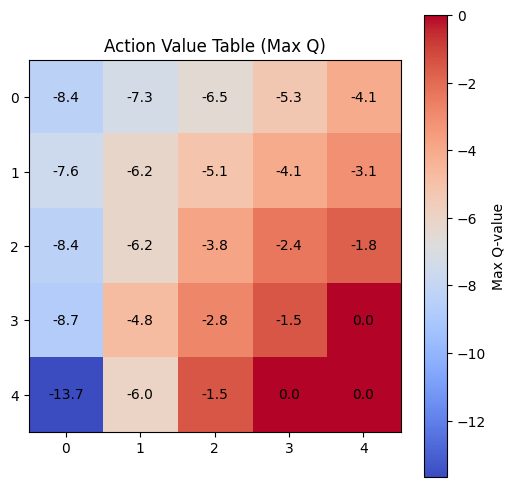

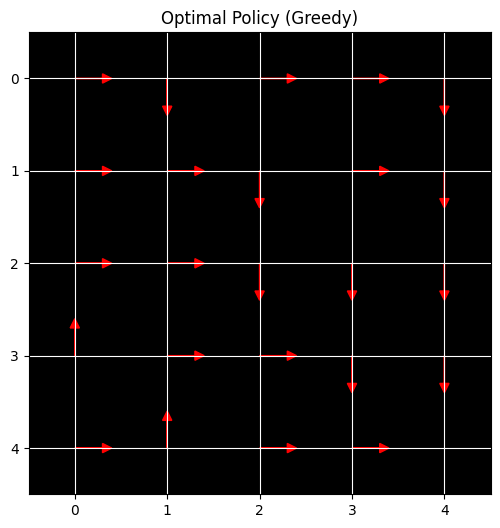

In [6]:
# Q값 히트맵
plot_action_values(action_values)

# 최적 정책 화살표
plot_policy(action_values)

### 4.2 에이전트 주행 테스트

학습된 정책으로 에이전트가 목표를 찾아가는지 확인한다.

테스트 종료


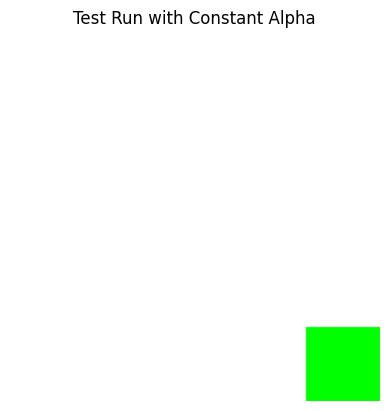

In [7]:
def test_run(env, policy):
    state, _ = env.reset()
    done = False
    step = 0
    img = plt.imshow(env.render())
    plt.axis('off')
    plt.title("Test Run with Constant Alpha")

    while not done and step < 20:
        action = policy(tuple(state), epsilon=0.0) # Greedy
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        step += 1
    print("테스트 종료")

test_run(env, policy)

### 요약

상수 알파를 사용하면 모든 데이터를 기억하거나 방문 횟수를 카운트할 필요 없이 값을 효율적으로 업데이트할 수 있다. 특히 최근의 경험을 더 중요하게 생각하기 때문에, 환경이 변하거나 학습 초기에 정책이 빠르게 변해야 할 때 유용하다.  값은 하이퍼파라미터로, 너무 크면 값이 진동하고 너무 작으면 학습이 느려지므로 적절한 값을 찾는 것이 중요하다.